# Project: Identify Customer Segments

Data cleaning, principal components analysis, and clustering in Python.

Author: Christoph Schauer
Date: 15/11/2018

----
## Introduction

This jupyter notebook is an updated version of my course project for the module Unsupervised Learning of [Udacity's Data Scientist Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025). 

From the description of the project:

*In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a company. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partner.*

The data used in this project is real-life data provided by a partner company of Udacity. As this data is confidential, I cannot upload the data itself, and I have to anonymize it before uploading this project: All company, file, and column names have been removed. Without this context, the content of the data is meaningless - and unfortunately the results are not interpretable in any meaningful way either.

I also edited Udacity's (quite verbose) descriptions a bit for the sake of brevity.

In [74]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Step 0: Load the Data

There are four files associated with this project (not including this one):

- Demographics_Subset.csv: Demographics data for the general population of country X; 891211 persons (rows) x 85 features (columns).
- Customer_Subset.csv: Demographics data for customers of company X; 191652 persons (rows) x 85 features (columns).
- Data_Dictionary.md: Detailed information file about the features in the provided datasets.
- Feature_Summary.csv: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary.

In [75]:
# Load in the general demographics data.
demo_data = pd.read_csv("Demographics_Subset.csv", sep=";")
demo_data.columns = list(range(1, 86))

# Load in the feature summary file.
feat_info = pd.read_csv("Feature_Summary.csv", sep = ";")
feat_info = feat_info.drop(columns="attribute")
feat_info["attribute"] = list(range(1, 86))

In [76]:
# Check the structure of the data
print("Number of rows and columns:", demo_data.shape)
display(demo_data.head())

Number of rows and columns: (891221, 85)


,1,2,3,4,5,6,7,8,9,10,...,76,77,78,79,80,81,82,83,84,85
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value.

In [77]:
# Identify missing or unknown data values and convert them to NaNs.

# Create list of missing value types
na_types = list(feat_info["missing_or_unknown"].unique())
print("NA types:", na_types)

# Convert missing value types to integers where possible
na_types_clean = [[-1,0], [-1,0,9], [0], [-1], [], [-1,9], [-1,"X"], ["XX"], [-1,"XX"]]

# Get columns for each NA type
na_columns = []
for i in na_types:
    storage = list(feat_info["attribute"].loc[feat_info["missing_or_unknown"] == i])
    na_columns.append(storage)
    
# Remove missing value type [] from the lists above, otherwise the loop below breaks
na_types.pop(4)
na_types_clean.pop(4)
na_columns.pop(4)

# Loop over column lists for each missing value type and replace all missing values with NaN
for i in range(0, len(na_types)):
        demo_data[na_columns[i]] = demo_data[na_columns[i]].replace(na_types_clean[i], np.nan)

NA types: ['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]', '[XX]', '[-1,XX]']


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe.

For the remaining features, are there any patterns in which columns have, or share, missing data?

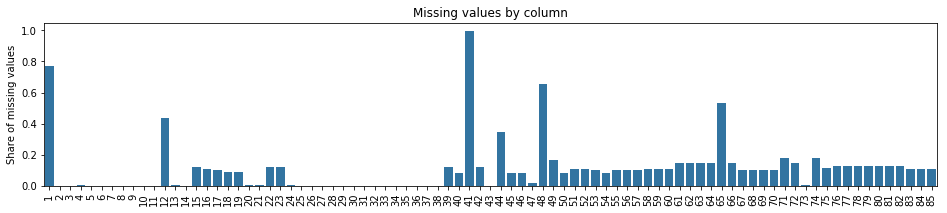

In [78]:
# Perform an assessment of how much missing data there is in each column of the dataset.

na_share = demo_data.isnull().sum()/len(demo_data)
plt.figure(figsize=(16, 3))
base_color = sns.color_palette()[0]
sns.barplot(na_share.index.values, na_share, color = base_color)
plt.xticks(rotation=90)
plt.title("Missing values by column")
plt.ylabel("Share of missing values");

In [79]:
# Remove the outlier columns from the dataset.

# 6 variables have more than 20% missing values and are dropped from the dataset  
na_share = demo_data.isnull().sum()/len(demo_data)
na_columns = list(na_share[na_share >= 0.2].index)
print("Variables with more than 20% missing values:", na_columns)

demo_data = demo_data.drop(columns=na_columns)

Variables with more than 20% missing values: [1, 12, 41, 44, 48, 65]


#### Discussion 1.1.2: Assess Missing Data in Each Column

As shown in the plot above, about one half of all variables in the dataset includes no or almost no missing values. In another half, about 10-15% of observations are missing. This pattern suggests that these two groups of data might come from different sources.

Finally, 6 variables have a high amount of missing values - between 35% and almost 100% - and were dropped from the dataset, These 6 variables are 1, 12, 41, 44, 48, 65. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

Average number of missing values per row: 5.649893797385833


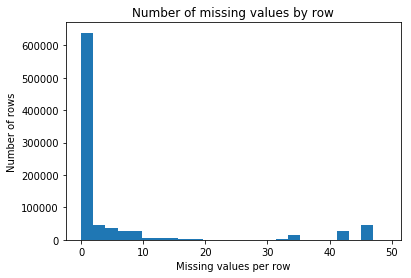

In [80]:
# How much data is missing in each row of the dataset?

na_count = demo_data.isnull().sum(axis=1)

# On average, 5.6 observations are missing in each row:
print("Average number of missing values per row:", na_count.sum()/len(na_count))

plt.hist(data=demo_data, x=na_count, bins=25)
plt.title("Number of missing values by row")
plt.xlabel("Missing values per row")
plt.ylabel("Number of rows");

In [81]:
# Write code to divide the data into two subsets based on 
# the number of missing values in each row.

# The sample is divided between in one group with more than 10 
# and one group with at most 10 missing values per row
demo_data["NA_number"] = demo_data.isnull().sum(axis = 1)
demo_data["NA_category"] = np.where(demo_data["NA_number"] > 10, "many", "few")

print("Number of rows with <= 10 NA's:", 
      len(demo_data.loc[demo_data["NA_category"] == "few"]))
print("Number of rows with > 10 NA's:", 
      len(demo_data.loc[demo_data["NA_category"] == "many"]))

# There is also a substantial amount of rows with no 
# and a high number of missing values, respectively 
print("Number of rows with 0 NA's:", 
      len(demo_data.loc[demo_data["NA_number"] == 0]))
print("Number of rows with > 30 NA's:", 
      len(demo_data.loc[demo_data["NA_number"] > 30]))

Number of rows with <= 10 NA's: 780153
Number of rows with > 10 NA's: 111068
Number of rows with 0 NA's: 623209
Number of rows with > 30 NA's: 93154


In [54]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Removed because of confidentiality

#### Discussion 1.1.3: Assess Missing Data in Each Row

After removing the outlier columns in terms of missing values, about 2/3 of all observations in the data set - more than 600,000 of almost 900,000 in total - have no missing values, as the bar chart and printed code above show. Roughly 200,000 observations have between 1 and 10 missing values. On the other end of the spectrum, some 100,000 observations have a high number of missing values, 30 or more. Only few observations fall in between.

The sample is divided between rows with at most 10 and rows with more than 10 missing values. The latter group is later dropped from the data set.

The distributions of five randomly selected non-binary columns are usually similar (enough) between the two subsets with few and many missing values, respectively. That is, for the purpose of this exercise, the distributions are similar enough so as not to necessitate special treatment.

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [84]:
# How many features are there of each data type? 

feat_info["type"].value_counts()
# The variable of type "interval" is dropped anyway during 
# the subsequent operations and can therefore be ignored

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [85]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

# Remove already dropped features from feat_info
feat_info = feat_info[-feat_info["attribute"].isin(na_columns)]

# Create a list of categorical variables
categorical = feat_info["attribute"].loc[feat_info["type"] == "categorical"].tolist()

# Show factor levels of categorical features
print("Factor levels:")
for i in range(0, len(categorical)):
    print(categorical[i], ": ", demo_data[categorical[i]].unique())

Factor levels:
3 :  [1 2]
4 :  [ 2.  5.  3.  4.  1.  6. nan]
11 :  [4 1 6 5 2 3]
13 :  [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
14 :  [0 1]
18 :  [ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
19 :  [ 2.  3.  1. nan  5.  4.]
20 :  [ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]
21 :  [ 1.  2.  4.  5.  3. nan]
22 :  [nan  1.  3.  2.]
39 :  [nan  3.  2.  1.  0.]
40 :  [nan  1.  0.]
42 :  [nan  2.  1.]
43 :  [3 5 4 1 6 2]
53 :  [nan  8.  1.  3.  2.  6.  4.  5.]
56 :  [nan 'W' 'O']
58 :  [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
59 :  [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


In [86]:
# Create list of binary features
binary = [3, 14, 40, 42, 56]

# Convert 56 to numeric
demo_data[56] = demo_data[56].replace({"W": 0, "O": 1})

In [87]:
# Create list of non-binary categorical features
non_binary = [i for i in categorical if i not in binary]

# Drop 59"
demo_data = demo_data.drop(columns=59)
non_binary.remove(59)
categorical.remove(59)

# One hot encode non-binary categorical features
features_onehot = demo_data[non_binary].applymap(str)
features_onehot = pd.get_dummies(features_onehot)
features_non_binary = features_onehot

# Drop original non-binary categorical features
demo_data = demo_data.drop(non_binary, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

##### Binary features:
The dataset contains 5 binary features. 56 was re-encoded as numeric variable. All other binary features were already numeric and not further processed.

##### Non-binary features:
The dataset contains 11 non-binary categorical features. 59 was dropped because thise feature is very similar to 58 and has a large number of levels, which would add a lot of dummy variables after one hot encoding. All other non-binary categorical features were one hot encoded and the original variables that were dropped.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- 23 combines information on three dimensions: Description removed because of confidentiality
- 60 combines information on two axes: Description removed because of confidentiality
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

In [88]:
# Investigate 23 and engineer two new variables.

dec = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70,
       9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15 :90}
demo_data["DEC"] = demo_data[23].replace(dec)

mov = {1: "M", 2: "A", 3: "M",4: "A", 5: "M", 
       6: "A", 7: "A", 8: "M", 9: "A",  10: "M",  
       11: "A",  12: "M", 13: "A",  14: "M", 15: "A"}
demo_data["MOV"] = demo_data[23].replace(mov)

# Convert to numeric
demo_data["MOV"] = demo_data["MOV"].replace({"M": 0, "A": 1})

# Drop original feature
demo_data = demo_data.drop(columns=23)

In [89]:
# Investigate 60 and engineer two new variables.

demo_data[60] = pd.to_numeric(demo_data[60])
w = {11: 5, 12: 5, 13: 5, 14: 5, 15: 5, 
     21: 4, 22: 4, 23: 4, 24: 4, 25: 4,
     31: 3, 32: 3, 33: 3, 34: 3, 35: 3,
     41: 2, 42: 2, 43: 2, 44: 2, 45: 2,
     51: 1, 52: 1, 53: 1, 54: 1, 55: 1}
demo_data["W"] = demo_data[60].replace(w)

ls = {11: 1, 12: 2, 13: 3, 14: 4, 15: 5, 
      21: 1, 22: 2, 23: 3, 24: 4, 25: 5,
      31: 1, 32: 2, 33: 3, 34: 4, 35: 5,
      41: 1, 42: 2, 43: 3, 44: 4, 45: 5,
      51: 1, 52: 2, 53: 3, 54: 4, 55: 5}
demo_data["LS"] = demo_data[60].replace(ls)

# Drop original feature
demo_data = demo_data.drop(columns=60)

In [90]:
# One hot encode mixed categorical features
mixed = [57, 80]
features_onehot = demo_data[mixed].applymap(str)
features_onehot = pd.get_dummies(features_onehot)
features_mixed = features_onehot

# drop original columns
demo_data = demo_data.drop(columns=mixed)

In [91]:
# Drop 16 &  17
# These two features are very similar to 60
demo_data = demo_data.drop(columns=[16, 17])

#### Discussion 1.2.2: Engineer Mixed-Type Features

Removed because of confidentiality

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [92]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# No other re-engineering tasks were performed

In [94]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Concatenate demographics dataframe with one hot encoded features
demo_data = pd.concat([demo_data, features_non_binary, features_mixed], axis=1)

# remove rows with many NaN (>10)
demo_data = demo_data.drop(demo_data[demo_data["NA_category"] == "many"].index)

# Drop useless columns: NA_category and NA_number
demo_data = demo_data.drop(["NA_number", "NA_category"], axis = 1)

print("Shape of the dataset:", demo_data.shape)
print("Remaining columns in the dataset:", demo_data.columns.values.tolist())

Shape of the dataset: (780153, 173)
Remaining columns in the dataset: [2, 3, 5, 6, 7, 8, 9, 10, 14, 15, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 45, 46, 47, 49, 50, 51, 52, 54, 55, 56, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 'DEC', 'MOV', 'W', 'LS', '4_1.0', '4_2.0', '4_3.0', '4_4.0', '4_5.0', '4_6.0', '4_nan', '11_1', '11_2', '11_3', '11_4', '11_5', '11_6', '13_1.0', '13_10.0', '13_11.0', '13_12.0', '13_2.0', '13_3.0', '13_4.0', '13_5.0', '13_6.0', '13_7.0', '13_8.0', '13_9.0', '13_nan', '18_1.0', '18_10.0', '18_11.0', '18_2.0', '18_3.0', '18_4.0', '18_5.0', '18_6.0', '18_7.0', '18_8.0', '18_9.0', '18_nan', '19_1.0', '19_2.0', '19_3.0', '19_4.0', '19_5.0', '19_nan', '20_1.0', '20_10.0', '20_2.0', '20_3.0', '20_4.0', '20_5.0', '20_6.0', '20_7.0', '20_8.0', '20_9.0', '20_nan', '21_1.0', '21_2.0', '21_3.0', '21_4.0', '21_5.0', '21_nan', '22_1.0', '22_2.0', '22_3.0', '22_nan', '39_0.0', '39_1.0', '39_2.0', '39_

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [98]:
def clean_data(source):

    # load data
    df = pd.read_csv(source, sep=";")
    df.columns = list(range(1, 86))

    feat_info = pd.read_csv("Feature_Summary.csv", sep=";")
    feat_info = feat_info.drop(columns="attribute")
    feat_info["attribute"] = list(range(1, 86))
    
    # convert missing values to NaN
    na_types = list(feat_info["missing_or_unknown"].unique())
    na_types_clean = [[-1,0], [-1,0,9], [0], [-1], [], [-1,9], [-1,"X"], ["XX"], [-1,"XX"]]
    na_columns = []
    for i in na_types:
        storage = list(feat_info["attribute"].loc[feat_info["missing_or_unknown"] == i])
        na_columns.append(storage)
    na_types.pop(4)
    na_types_clean.pop(4)
    na_columns.pop(4)
    for i in range(0, len(na_types)):
            df[na_columns[i]] = df[na_columns[i]].replace(na_types_clean[i], np.nan)

    # drop columns with more than 20% NaN in demographics dataset
    na_columns = [1, 12, 41, 44, 48, 65]
    df = df.drop(columns = na_columns)
    # as they need to be same columns in both datasets, and the customer data
    # has many columns with lots of NaN, these columns are hardcoded here
    
    # deal with binary and non-binary categorical features
    feat_info = feat_info[-feat_info["attribute"].isin(na_columns)]
    categorical = feat_info["attribute"].loc[feat_info["type"] == "categorical"].tolist()
    binary = [3, 14, 40, 42, 56]
    df[56] = df[56].replace({"W": 0, "O": 1})
    non_binary = [i for i in categorical if i not in binary]
    df = df.drop(columns=59)
    non_binary.remove(59)   
    categorical.remove(59)

    # one hot encode non-binary categorical features
    features_onehot = df[non_binary].applymap(str)
    features_onehot = pd.get_dummies(features_onehot)
    features_non_binary = features_onehot
    df = df.drop(non_binary, axis=1)

    # mixed categorical features - PRAEGENDE_JUGENDJAHRE
    dec = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70,
           9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15 :90}
    df["DEC"] = df[23].replace(dec)
    mov = {1: "M", 2: "A", 3: "M",4: "A", 5: "M", 
           6: "A", 7: "A", 8: "M", 9: "A",  10: "M",  
           11: "A",  12: "M", 13: "A",  14: "M", 15: "A"}
    df["MOV"] = df[23].replace(mov)
    df["MOV"] = df["MOV"].replace({"M": 0, "A": 1})
    df = df.drop(columns=23)
    
    # mixed categorical features - 60
    df[60] = pd.to_numeric(df[60])
    wealth = {11: 5, 12: 5, 13: 5, 14: 5, 15: 5, 
              21: 4, 22: 4, 23: 4, 24: 4, 25: 4, 
              31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 
              41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 
              51: 1, 52: 1, 53: 1, 54: 1, 55: 1}
    df["W"] = df[60].replace(w)
    ls = {11: 1, 12: 2, 13: 3, 14: 4, 15: 5, 
          21: 1, 22: 2, 23: 3, 24: 4, 25: 5,
          31: 1, 32: 2, 33: 3, 34: 4, 35: 5,
          41: 1, 42: 2, 43: 3, 44: 4, 45: 5,
          51: 1, 52: 2, 53: 3, 54: 4, 55: 5}
    df["LS"] = df[60].replace(ls)
    df = df.drop(columns=60)
    
    # one hot encode mixed categorical features
    mixed = [57, 80]
    features_onehot = df[mixed].applymap(str)
    features_onehot = pd.get_dummies(features_onehot)
    features_mixed = features_onehot
    df = df.drop(columns = mixed)
    
    # Drop 16 &  17
    df = df.drop(columns=[16, 17])
    
    # concatenate dataframe with one hot encoded features
    df = pd.concat([df, features_non_binary, features_mixed], axis = 1)

    # remove rows with many NaN (>10)
    df["NA_number"] = df.isnull().sum(axis = 1)
    df["NA_category"] = np.where(df["NA_number"] > 10, "many", "few")
    df = df.drop(df[df["NA_category"] == "many"].index)

    # drop useless columns: NA_category and NA_number
    df = df.drop(["NA_number", "NA_category"], axis = 1)

    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [100]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# drop rows with missing values
print("Dataset shape before:", demo_data.shape)
demo_data = demo_data.dropna()
print("Dataset shape after:", demo_data.shape)
# some 150,000 rows are dropped

Dataset shape before: (780153, 173)
Dataset shape after: (623211, 173)


In [103]:
# Apply feature scaling to the general population demographics data.

# Scale features with to mean = 0 and std = 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
demo_data_scaled = scaler.fit_transform(demo_data)

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Discussion 2.1: Apply Feature Scaling

All remaining rows with missing values were drop from the dataset. As the dataset is still sufficiently large afterwards, missing values were not imputed.

All features were scaled using sklearn's MinMaxScaler() function with the default options. The function by default scales all variables to a mean of 0 and a standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [104]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

# Calculate the first 100 principal components
pca = PCA(n_components=100)
demo_data_pca = pca.fit_transform(demo_data_scaled)
demo_data_pca = pd.DataFrame(data=demo_data_pca)

In [105]:
# Investigate the variance accounted for by each principal component.

print("Explained variance in % of the first 100 principal components:")
print(pca.explained_variance_ratio_ * 100)

Explained variance in % of the first 100 principal components:
[12.06398527  8.20582074  5.42260655  4.51819984  3.75747156  2.51390753
  2.3376612   2.00124227  1.97515397  1.89091517  1.78921595  1.73672359
  1.68925743  1.59923943  1.49280009  1.40325756  1.35950463  1.30209165
  1.18279686  1.14820166  1.12606749  1.09963467  1.01764378  0.99468358
  0.9889528   0.95009131  0.90844497  0.89763615  0.87497231  0.85435624
  0.83656321  0.80350328  0.79321536  0.78003043  0.75261963  0.7420717
  0.73020605  0.71173112  0.69512866  0.69288105  0.66097932  0.65049904
  0.64187878  0.63815468  0.62585653  0.61369612  0.59929642  0.5784341
  0.57416385  0.56244641  0.54718847  0.54301596  0.52745177  0.51192953
  0.50183009  0.49732102  0.46586831  0.45980839  0.45717504  0.45517775
  0.43465356  0.42391461  0.41906051  0.40814988  0.39253302  0.37070875
  0.3587945   0.34694848  0.33889101  0.33193667  0.32009603  0.31375872
  0.30618076  0.29635196  0.29204367  0.2800672   0.26535087  0

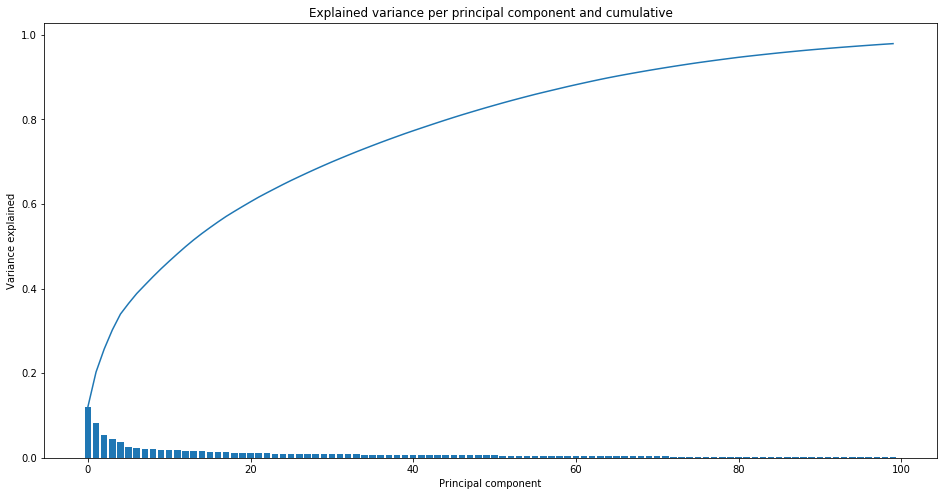

In [106]:
num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)
plt.figure(figsize=(16, 8))
ax = plt.subplot()
ax.bar(ind, vals)
ax.plot(ind, cumvals)
ax.set_xlabel("Principal component")
ax.set_ylabel("Variance explained")
plt.title("Explained variance per principal component and cumulative");

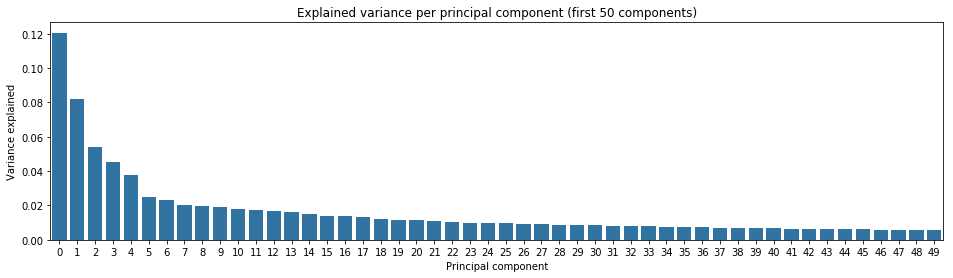

In [108]:
# to get a better view of the variance explained by each component
plt.figure(figsize = (16, 4))
sns.barplot(ind[0:50], vals[0:50], color = base_color)
plt.title("Explained variance per principal component (first 50 components)")
plt.xlabel("Principal component")
plt.ylabel("Variance explained");

In [109]:
# Re-apply PCA to the data while selecting for number of components to retain.

print("Variance explained by the first 40 components:", cumvals[39])

pca = PCA(n_components=40)
demo_data_pca = pca.fit_transform(demo_data_scaled)
demo_data_pca = pd.DataFrame(data=demo_data_pca)

Variance explained by the first 40 components: 0.7664048673531987


### Discussion 2.2: Perform Dimensionality Reduction

The curve of the accumulated explained variance of the principal components and the (implicit) curve in the bar charts of the explained variance per individual components are pretty smooth. The dropoff in variance explained is pretty sharp for the first 5 principal components, which together explain about 40% of total variance, but if you want to include more than 5, a natural cutoff point is not really readily apparent. Therefore 40 principal components were selected, because it is a round number und still fast to compute. These 40 account for 76.6% in the variance in the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component.

In [130]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def pc_weights(component):
    ls = list(zip(pca.components_[component-1], demo_data.columns))
    ls.sort(key = lambda x: x[0], reverse=True)
    return ls

# weights and features for the first principal component
pc1_weights = pc_weights(1)

# print first 20 weights
pc1_weights[0:20]

[(0.2795936190696385, '21_1.0'),
 (0.17891736432540326, 79),
 (0.17370920943069101, '20_1.0'),
 (0.16464360966740302, 78),
 (0.15307875666881252, 47),
 (0.14149937061560902, 68),
 (0.13657880354577728, '18_1.0'),
 (0.13657880354577728, '19_1.0'),
 (0.135983029101506, '11_1'),
 (0.13344352130269532, 10),
 (0.12573616343629637, 6),
 (0.12160132825169075, 84),
 (0.11201177827932966, 63),
 (0.11067674675436065, 64),
 (0.10588440963894731, '20_2.0'),
 (0.10554241993684527, '80_5.0'),
 (0.10530715896070307, '58_9'),
 (0.09758269469483076, '58_8'),
 (0.09543929009314832, 85),
 (0.0779402421557491, 37)]

In [137]:
# last 10 weights
pc1_weights[-10:]

[(-0.125059896950407, '21_5.0'),
 (-0.12744642358929098, '53_1.0'),
 (-0.13927177859601192, 14),
 (-0.13927177859601192, 'MOV'),
 (-0.1613114817832534, 72),
 (-0.1660782659815835, 66),
 (-0.18006862401494303, 'W'),
 (-0.1847314435249625, 5),
 (-0.1903479212165371, 61),
 (-0.23988152690319628, '80_1.0')]

In [134]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc2_weights = pc_weights(2)

# print first 20 weights
pc2_weights[0:20]

[(0.29469296975345566, '43_3'),
 (0.2284184166223458, 2),
 (0.21258058649693878, 7),
 (0.16947439125721978, 24),
 (0.16402977226395232, 30),
 (0.1623678929319908, 31),
 (0.1383655421750027, '20_1.0'),
 (0.1281116846075091, 49),
 (0.11850239297561124, '4_2.0'),
 (0.10997609262519256, '18_1.0'),
 (0.10997609262519256, '19_1.0'),
 (0.10556716164991606, '11_6'),
 (0.0924778069775244, '39_3.0'),
 (0.09075247657888806, '11_5'),
 (0.08236658099828766, 5),
 (0.0822639010920567, 10),
 (0.07658359705683149, '11_2'),
 (0.07167666764955097, 79),
 (0.07027095922670372, 34),
 (0.06743044343670417, 78)]

In [135]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc3_weights = pc_weights(3)

# print first 20 weights
pc3_weights[0:20]

[(0.2832802469869157, 29),
 (0.22943331456798352, 25),
 (0.22872850137720233, 26),
 (0.22386119416018052, 32),
 (0.1395130997959277, '11_5'),
 (0.13105445135012353, '39_0.0'),
 (0.12220428644882722, 5),
 (0.11995103015463135, '43_1'),
 (0.11885716292173581, 14),
 (0.11885716292173581, 'MOV'),
 (0.10050994426252695, 27),
 (0.08526953685206101, 24),
 (0.0801536133082083, 68),
 (0.07766066594796585, '39_1.0'),
 (0.07338372517641668, '20_10.0'),
 (0.07338372517641668, '21_5.0'),
 (0.07298280588922405, 28),
 (0.06733484155831643, 84),
 (0.06321029311990951, 49),
 (0.06011300591588375, '20_1.0')]

### Discussion 2.3: Interpret Principal Components

Removed because of confidentiality.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.

Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [175]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans
from scipy.spatial import distance
    
awcd_list = []
score_list = []

def get_kmeans_metrics(data):
    
    # Over a number of different cluster counts...
    for k in k_list:
        
        # run k-means clustering on the data and...
        kmeans = KMeans(n_clusters=k, n_jobs=-1) # use all CPU cores
        model = kmeans.fit(data)
        labels = kmeans.predict(data)    
        centers = model.cluster_centers_

        # compute the average within-cluster distances.
        cluster_list = list(range(0, k))
        distances = []
        
        for i in cluster_list:
            distances_i = distance.cdist(data[labels == i], [centers[i]], "euclidean")
            distances_i = distances_i.tolist()
            distances_i = [y for x in distances_i for y in x]
            distances = distances + distances_i
        # As I realized later, the average within-cluster distance is equal to the square root of the score()
        # so this part is needlessly complicated
        
        awcd = np.mean(distances)
        awcd_list.append(awcd)
        
        # (plus the score, the sum of squared distances)
        score = abs(model.score(data))
        score_list.append(score)
        
        print("Training complete for number of clusters:", k)

In [176]:
# Pass 15 numbers of K to the function, from 2 to 30 in steps of 2
k_list = list(range(2,31,2))
print("Number of K clusters:", k_list)

# initiate empty score lists
awcd_list = []
score_list = []

# run function (takes a while)
get_kmeans_metrics(demo_data_pca)

Number of K clusters: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
Training complete for number of clusters: 2
Training complete for number of clusters: 4
Training complete for number of clusters: 6
Training complete for number of clusters: 8
Training complete for number of clusters: 10
Training complete for number of clusters: 12
Training complete for number of clusters: 14
Training complete for number of clusters: 16
Training complete for number of clusters: 18
Training complete for number of clusters: 20
Training complete for number of clusters: 22
Training complete for number of clusters: 24
Training complete for number of clusters: 26
Training complete for number of clusters: 28
Training complete for number of clusters: 30


In [177]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

awcd_list_zipped = list(zip(k_list, awcd_list))

print("Number of clusters, Average within-cluster distance")
awcd_list_zipped

Number of clusters, Average within-cluster distance


[(2, 3.29016542754622),
 (4, 3.09598518136335),
 (6, 2.9988728545788104),
 (8, 2.9317097333503566),
 (10, 2.885203840291292),
 (12, 2.8471108654925867),
 (14, 2.8159306583766557),
 (16, 2.791538882335322),
 (18, 2.7705578531765243),
 (20, 2.75121761264068),
 (22, 2.7338596085553224),
 (24, 2.714091567925657),
 (26, 2.6979710268750394),
 (28, 2.6860261076091105),
 (30, 2.6674055798346803)]

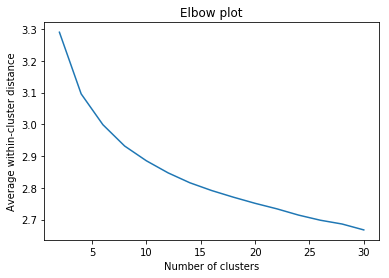

In [178]:
plt.plot(k_list, awcd_list)
figsize=(16, 8)
plt.title("Elbow plot")
plt.xlabel("Number of clusters")
plt.ylabel("Average within-cluster distance");

In [148]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Initialize the model with K = 8 and a random seed for consistent results
kmeans_demo_data = KMeans(n_clusters=8, random_state=123, n_jobs=-1)
model_demo_data = kmeans_demo_data.fit(demo_data_pca)
score_demo_data = abs(model_demo_data.score(demo_data_pca))

# Cluster labels
predictions_demo_data = kmeans_demo_data.predict(demo_data_pca) 

print(kmeans_demo_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)


### Discussion 3.1: Apply Clustering to General Population

The curve in the plot above has a pretty smooth bend between K = 4 and = 12. With the elbow method, there is no obvious number of K to choose for K-Means clustering - that is to say, the "elbow" isn't very sharp. Terefore K = 8 was chosen, the value in the middle of the bend.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

In [144]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# load in the customer demographics data
customers = clean_data("Customers_Subset.csv")

# drop missing remaining rows with missing values
customers = customers.dropna()

# scale features
customers_scaled = scaler.fit_transform(customers)

# apply pca with 40 principal components
customers_pca = pca.fit_transform(customers_scaled)
customers_pca = pd.DataFrame(data=customers_pca)

# cluster data without changing sklearn objects
predictions_customers = kmeans_demo_data.predict(customers_pca)

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of country X, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups.
- Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis.
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

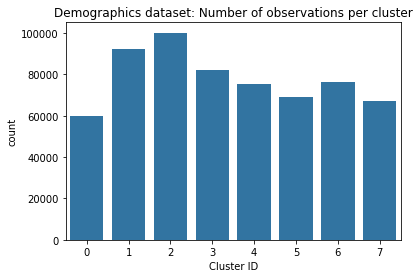

In [149]:
sns.countplot(predictions_demo_data, color=base_color)
plt.title("Demographics dataset: Number of observations per cluster")
plt.xlabel("Cluster ID");

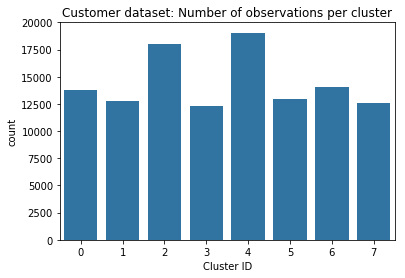

In [150]:
sns.countplot(predictions_customers, color=base_color)
plt.title("Customer dataset: Number of observations per cluster")
plt.xlabel("Cluster ID");

In [159]:
# number of observations per cluster, demographics dataset
counts_demo_data = np.unique(predictions_demo_data, return_counts=True)

# number of observations per cluster, customers dataset
counts_customers = np.unique(predictions_customers, return_counts=True)

# Observations per cluster in customer dataset relative to the demographics dataset:
list(zip(counts_demo_data[0], list((counts_customers[1]/len(customers_pca))/(counts_demo_data[1]/len(demo_data_pca)))))

[(0, 1.2416164606766846),
 (1, 0.7462028983935318),
 (2, 0.9702338438433986),
 (3, 0.805026189847869),
 (4, 1.3622491680532833),
 (5, 1.0115977764089412),
 (6, 0.9889971034438696),
 (7, 1.0108156197393807)]

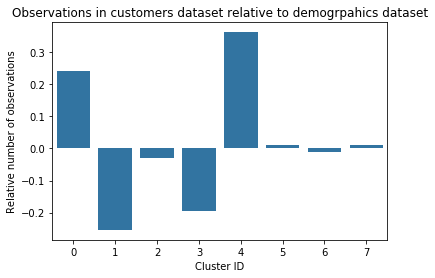

In [158]:
x = counts_demo_data[0]
y = (counts_customers[1]/len(customers_pca))/(counts_demo_data[1]/len(demo_data_pca))-1

sns.barplot(x, y, color = base_color)
plt.title("Observations in customers dataset relative to demogrpahics dataset")
plt.xlabel("Cluster ID")
plt.ylabel("Relative number of observations");

In [ ]:
# in cluster 4 , the customers dataset has about 35% more observations
# in cluster 1, the customers dataset has about 25% less

In [160]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# generate a dataframe with the feature names as index, 
# one column with the column means for all observations in the demographics dataset where the cluster has the ID 4,  
# one column with the column means of the rows in all other clusters combined, and
# one column with the ratio between the first two columns

labels_demo_data = pd.DataFrame(predictions_demo_data)
labels_demo_data = labels_demo_data.rename(columns = {0: "Cluster"})
demo_data_end = demo_data.reset_index()
demo_data_end = pd.concat([demo_data_end, labels_demo_data], axis=1)
demo_data_end = demo_data_end.drop(columns="index")

# column means of demographic data where cluster = 4
means_4 = demo_data_end[demo_data_end["Cluster"] == 4].mean(axis=0)

# column means of demographic data where cluster != 4
means_not4 = demo_data_end[demo_data_end["Cluster"] != 4].mean(axis=0)

mean_comp = pd.DataFrame(data = {"Cluster = 4": means_4, "Cluster != 4": means_not4})
mean_comp["Relative Difference"] = mean_comp["Cluster = 4"]/mean_comp["Cluster != 4"]
mean_comp = mean_comp.drop("Cluster")
mean_comp_sorted = mean_comp.sort_values(by = "Relative Difference", ascending = False)

In [163]:
# display first 10 lines in the dataframe
mean_comp_sorted.head(10)

,Cluster = 4,Cluster != 4,Relative Difference
20_5.0,0.218013,0.002619,83.227944
11_4,0.283685,0.042428,6.686250
20_4.0,0.331967,0.060204,5.514040
18_6.0,0.032312,0.006891,4.689054
11_3,0.121316,0.028268,4.291577
20_8.0,0.051864,0.012471,4.158664
21_2.0,0.621886,0.159412,3.901136
18_3.0,0.015413,0.004425,3.483361
13_9.0,0.165181,0.052607,3.139930
57_8.0,0.018292,0.006374,2.869558


In [164]:
# drop column 20_5.0 because of the huge ratio - above 80 - which would make the graphs below hard to read
# This large ratio might be due to a low number of observations
mean_comp_sorted = mean_comp_sorted.drop("20_5.0")

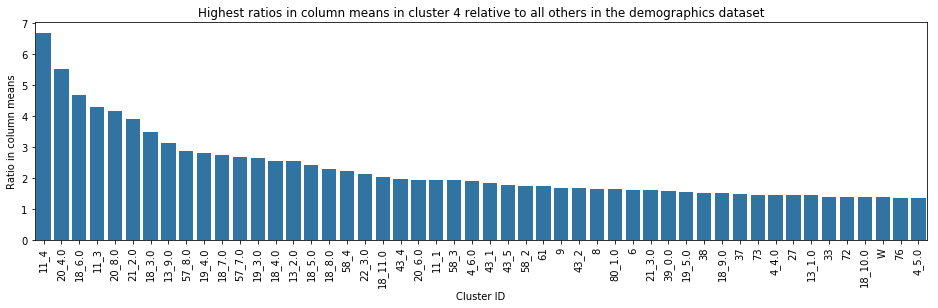

In [166]:
plt.figure(figsize=(16, 4))
sns.barplot(mean_comp_sorted.index[0:50], mean_comp_sorted["Relative Difference"][0:50], color = base_color)
plt.xticks(rotation = 90)
plt.title("Highest ratios in column means in cluster 4 relative to all others in the demographics dataset")
plt.xlabel("Cluster ID")
plt.ylabel("Ratio in column means");

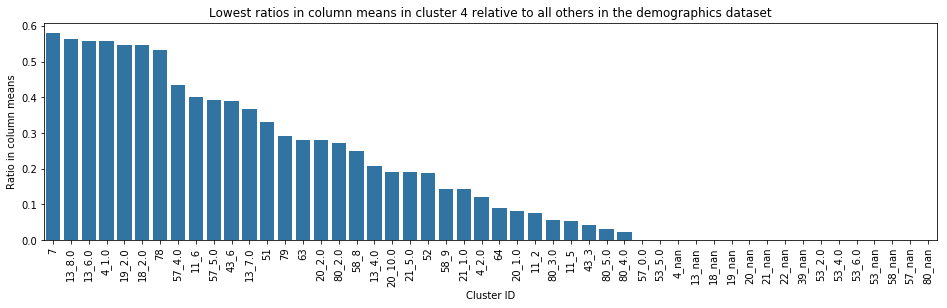

In [168]:
plt.figure(figsize=(16, 4))
sns.barplot(mean_comp_sorted.index[-50:], mean_comp_sorted["Relative Difference"][-50:], color = base_color)
plt.xticks(rotation = 90)
plt.title("Lowest ratios in column means in cluster 4 relative to all others in the demographics dataset")
plt.xlabel("Cluster ID")
plt.ylabel("Ratio in column means");

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [170]:
# generate a dataframe with the feature names as index, 
# one column with the column means for all observations in the demographics dataset where the cluster has the ID 1,  
# one column with the column means of the rows in all other clusters combined, and
# one column with the ratio between the first two columns

labels_demo_data = pd.DataFrame(predictions_demo_data)
labels_demo_data = labels_demo_data.rename(columns = {0: "Cluster"})
demo_data_end = demo_data.reset_index()
demo_data_end = pd.concat([demo_data_end, labels_demo_data], axis=1)
demo_data_end = demo_data_end.drop(columns = "index")

# column means of demographic data where cluster = 1
means_1 = demo_data_end[demo_data_end["Cluster"] == 1].mean(axis=0)

# column means of demographic data where cluster != 1
means_not1 = demo_data_end[demo_data_end["Cluster"] != 1].mean(axis=0)

mean_comp = pd.DataFrame(data = {"Cluster = 1": means_1, "Cluster != 1": means_not1})
mean_comp["Relative Difference"] = mean_comp["Cluster = 1"]/mean_comp["Cluster != 1"]
mean_comp = mean_comp.drop("Cluster")
mean_comp_sorted = mean_comp.sort_values(by = "Relative Difference", ascending = False)

In [171]:
# display first 10 lines in the dataframe
mean_comp_sorted.head(10)

,Cluster = 1,Cluster != 1,Relative Difference
20_9.0,0.885585,0.029328,30.196178
21_4.0,0.932841,0.041342,22.563939
57_8.0,0.024689,0.004881,5.058507
20_8.0,0.047256,0.012014,3.933283
57_7.0,0.539817,0.154874,3.485517
13_6.0,0.075779,0.025833,2.933356
13_7.0,0.108665,0.040291,2.697006
11_2,0.254765,0.105067,2.424790
58_4,0.254775,0.106415,2.394159
58_3,0.200719,0.084749,2.368400


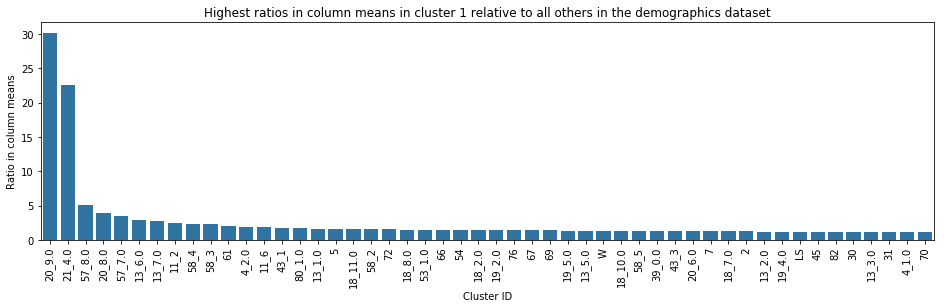

In [172]:
plt.figure(figsize=(16, 4))
sns.barplot(mean_comp_sorted.index[0:50], mean_comp_sorted["Relative Difference"][0:50], color = base_color)
plt.xticks(rotation = 90)
plt.title("Highest ratios in column means in cluster 1 relative to all others in the demographics dataset")
plt.xlabel("Cluster ID")
plt.ylabel("Ratio in column means");

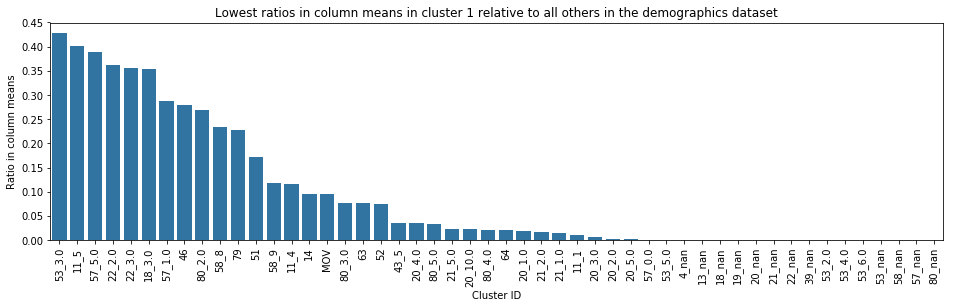

In [174]:
plt.figure(figsize=(16, 4))
sns.barplot(mean_comp_sorted.index[-50:], mean_comp_sorted["Relative Difference"][-50:], color = base_color)
plt.xticks(rotation = 90)
plt.title("Lowest ratios in column means in cluster 1 relative to all others in the demographics dataset")
plt.xlabel("Cluster ID")
plt.ylabel("Ratio in column means");

### Discussion 3.3: Compare Customer Data to Demographics Data

There are lots of variables in this dataset, so I'll focus on the most "extreme" clusters, 4 and 1, and the features with the highest ratios.

###### Popular population segments

Removed due to confidentiality. A discussion of anonymized and therefore meaningless variable names is not very insightful anyway.

##### Unpopular population segments

Removed due to confidentiality. A discussion of anonymized and therefore meaningless variable names is not very insightful anyway.